## Unconditional competing risks modeling with Aalen-Johanson

So far, we've been dealing with a single kind of risk: any accident. **What if we have different, mutually exclusive types of failure?**

This is the point of **competing risks modeling**. It aims at modeling the probability of incidence for different events, where these probabilities interfer with each other. Here we consider that a truck that had an accident is withdrawn from the fleet, and therefore can't experience any other ones.


Let's load our dataset another time. Notice that we have 3 types of event (plus the censoring 0):

In [3]:
import pandas as pd

truck_failure_competing_events = pd.read_parquet("data/truck_failure_10k_competing_risks.parquet")
truck_failure_competing_events

,event,duration
0,3,980.394661
1,2,1207.870100
2,0,125.000000
3,1,96.839004
4,2,88.077852
...,...,...
9995,2,0.435731
9996,2,356.591211
9997,1,847.951259
9998,2,25.551167


In this refined variant of the truck failure event data, the event identifiers mean the following:

- 1: manufacturing defect: a failure of a truck that happens as a result of mistakes in the assembly of the components (e.g. loose bolts);
- 2: operational failures, e.g. a driving accident;
- 3: fatigure induced failures, e.g. an engine breaks after heavy use for a prolongued period of time, despite good assembly and regular maintenance.

0 is still the censoring marker.

Instead of estimating a survival function (probability of remaining event free over time), a competing risk analysis model attempts to estimate a **cause-specific cumulative incidence function ($CIF_k$)**:

For any event $k \in [1, K]$, the cumulative incidence function of the event $k$ becomes:

$$CIF_k = P(T < t, \mathrm{event}=k)$$

In the unconditional case, the estimator ignore any side information in $X$ and only models $CIF_k(t)$ from information in $y$: event types and their respective durations (often with censoring).

**Aalen-Johanson estimates the CIF for multi-event $k$**, by:
- estimating the cause-specific hazards on one hand;
- estimating the global (any event) survival probabilities using Kaplan-Meier on the other hand.

The two estimates are then combined to produce an estimate of the cause-specific cumulative incidence.

<details><summary>Mathematical formulation</summary>

<br>
We first compute the cause-specific hazards $\lambda_k$, by simply counting for each individual duration $t_i$ the number of individuals that have experienced the event $k$ at $t_i$ ($d_{i,k}$), and the number of people still at risk at $t_i$ ($n_i$).

$$
\hat{\lambda}_k(t_i)=\frac{d_{k,i}}{n_i}
$$

Then, we compute the survival probability any event with Kaplan-Meier any event, where we can reused the cause-specific hazards.
    
$$
\hat{S}(t)=\prod_{i:t_i\leq t} (1 - \frac{d_i}{n_i})=\prod_{i:t_i\leq t} (1 - \sum_k\hat{\lambda}_{k}(t_i))
$$

Finally, we compute the CIF of event $k$ as the sum of the cause-specific hazards, weighted by the survival probabilities.

$$\hat{F}_k(t)=\sum_{i:t_i\leq t} \hat{\lambda}_k(t_i) \hat{S}(t_{i-1})$$
    
    
</details>

Let's use lifelines to estimate the ${CIF_k}$ using Aalen-Johanson. We need to indicate which event to fit on, so we'll iteratively fit the model on all events.

Fitting Aalen-Johansen for event 1...
Fitting Aalen-Johansen for event 2...
Fitting Aalen-Johansen for event 3...


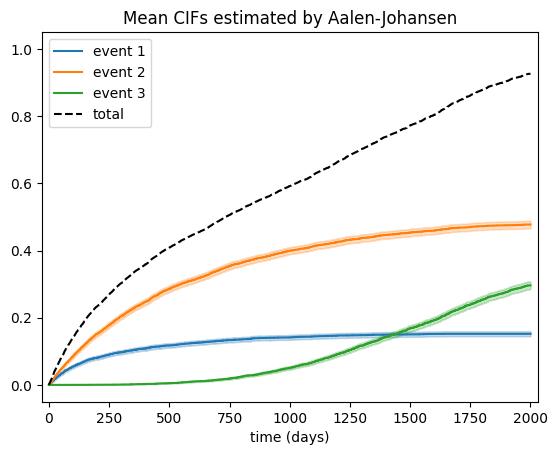

In [5]:
from matplotlib import pyplot as plt
from lifelines import AalenJohansenFitter

fig, ax = plt.subplots()

total_cif = None
competing_risk_ids = sorted(
    truck_failure_competing_events.query("event > 0")["event"].unique()
)
for event in competing_risk_ids:
    print(f"Fitting Aalen-Johansen for event {event}...")
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(
        truck_failure_competing_events["duration"],
        truck_failure_competing_events["event"],
        event_of_interest=event
    )
    ajf.plot(ax=ax, label=f"event {event}")
    cif_df = ajf.cumulative_density_
    cif_times = cif_df.index
    if total_cif is None:
        total_cif = cif_df[cif_df.columns[0]].values
    else:
        total_cif += cif_df[cif_df.columns[0]].values

ax.plot(cif_times, total_cif, label="total", linestyle="--", color="black")
ax.set(
    title="Mean CIFs estimated by Aalen-Johansen",
    xlabel="time (days)",
    xlim=(-30, 2030),
    ylim=(-0.05, 1.05),
)
plt.legend();

This unconditional model helps us identify 3 types of events, having momentum at different times. As expected:

- the incidence of type 1 events (failures caused by manufactoring defects) increase quickly from the start and then quickly plateau: after 1000 days, the estimator expects almost no new type 1 event to occur: all trucks with a manufacturing defect should have failed by that time.
- the incidence of type 2 events (failures caused by wrong operation of the truck) constantly accumulate throughout the observation period.
- the incidence of type 3 events (fatigure induced failures) is almost null until 500 days and then slowly increase.

Note that once a truck as failed from one kind of event (e.g. a manufacturing defect), it is taken out of the pool of trucks under study and can therefore no longer experience any other kind of failures: there are therefore many operational or fatigure induced failures that do no happen because some trucks have previously failed from a competing failure type.

Finally, we can observe that, as time progresses, operational and, even more importantly, fatigue induced failures are expected to make all the trucks in the study fail. Therefore, the sum of the cumulative incidence functions is expected to reach 100% in our study in the large time limit.

However, since all events beyond 2000 days are censored in our dataset, the Aaelen-Johansen estimator produces truncated incidence curves: it does not attempt to extra polate beyond the maximum event time observed in the data.

## Predictive competing risks analysis using our GradientBoostedCIF

Contrary to predictive survival analysis, the open source ecosystem is not very mature for predictive competing risk analysis.

However, `GradientBoostingIncidence` was designed in a way to optimize the cause-specific version of IBS: for each type of event $k$, we fit one `GradientBoostingIncidence` instance specialized for this kind of event by passing `event_of_interest=k` to the constructor.

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split


def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test["duration"] < y_train["duration"].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X = pd.read_parquet("data/truck_failure_10k_features.parquet")
y = truck_failure_competing_events

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, y, np.arange(X.shape[0]), test_size=0.75, random_state=0
)

In [16]:
from sklearn.pipeline import make_pipeline
from hazardous import GradientBoostedIncidence


y_train_cr = truck_failure_competing_events.loc[idx_train]
y_test_cr = truck_failure_competing_events.loc[idx_test]

cif_models = {}
for k in competing_risk_ids:    
    gb_cif_k = GradientBoostedIncidence(
        event_of_interest=k, max_leaf_nodes=15, n_iter=50, learning_rate=0.05
    )
    gb_cif_k = PipelineWrapper(gb_cif_k)
    gb_cif_k.fit(X_train, y_train_cr, time_grid)
    cif_models[k] = gb_cif_k

NameError: name 'simple_preprocessor' is not defined

Alternatively we can fit a larger model with the largest version of the same dataset (should take less a minute):

In [9]:
# truck_failure_competing_events_large = pd.read_parquet("truck_failure_100k_competing_risks.parquet")
# y_train_cr_large = truck_failure_competing_events_large.loc[train_large_mask]

# cif_models = {}
# for k in competing_risk_ids:    
#     gb_cif_k = make_pipeline(
#         simple_preprocessor,
#         GradientBoostedCIF(
#             event_of_interest=k, max_leaf_nodes=31, n_iter=100, learning_rate=0.1
#         ),
#     )
#     gb_cif_k = PipelineWrapper(gb_cif_k)
#     gb_cif_k.fit(X_train_large, y_train_cr_large, time_grid)
#     cif_models[k] = gb_cif_k

Once fit, we can use this family of model to predict individual CIF predictions for each kind of event. Plotting the average CIF across indiviuals in the test set should recover curves similar to the Aalean-Johansen estimates (in the limit of large training and test data):

In [ ]:
fig, ax = plt.subplots()
total_mean_cif = np.zeros(time_grid.shape[0])

gb_cif_cumulative_incidence_curves = {}
for k in competing_risk_ids:
    cif_curves_k = cif_models[k].predict_cumulative_incidence(X_test, time_grid)
    gb_cif_cumulative_incidence_curves[k] = cif_curves_k
    mean_cif_curve_k = cif_curves_k.mean(axis=0)  # average over test points
    ax.plot(time_grid, mean_cif_curve_k, label=f"event {k}")
    total_mean_cif += mean_cif_curve_k

ax.plot(time_grid, total_mean_cif, label="total", linestyle="--", color="black")
ax.set(
    title="Mean CIFs estimated by GradientBoostingCIF",
    xlabel="time in days",
    ylabel="Cumulative Incidence",
    xlim=(-30, 2030),
    ylim=(-0.05, 1.05),
)
plt.legend();

The average cause-specific cumulative incidence curves seems to mostly agree with the Aalen-Johansen estimate. One can observe some problematic discrepancy though (depending on the choice of the hyper-parameters):

- the cumulative incidence of event 1 and 2 do not start at 0 as expected;
- the cumulative incidence of event 1 seems to continue growing beyond day 1500 which is not expected either.

On aggregate we can therefore expect the total incidence to be over estimated on the edges of the time range.

Let also reuse the any-event survival estimates to check that:

$$\hat{S}(t) \approx 1 - \sum_k \hat{CIF_k}(t)$$


In [ ]:
fig, ax = plt.subplots()
mean_survival_curve = gb_cif_large_survival_curves.mean(axis=0)
ax.plot(time_grid, total_mean_cif, label="Total CIF")
ax.plot(time_grid, mean_survival_curve, label="Any-event survival")
ax.plot(
    time_grid,
    total_mean_cif + mean_survival_curve,
    color="black",
    linestyle="--",
    label="Survival + total CIF",
)
ax.legend();

So we see that our Gradient Boosting CIF estimator seems to be mostly unbiased as the sum of the mean CIF curves then mean any-event survival curve randomly fluctuates around 1.0. A more careful study would be required to see how the mean and the variance of the sum evolve when changing the size of the training set, the amount of censoring and the hyperparameters of the estimator.

In particular, it's possible that it would be beneficial to tune the hyper-parameters of each cause-specific model indpendently using a validation and early stopping.

Note: we could also attempt to constrain the total CIF and survival estimates to always sum to 1 by design but this would make it challenging (impossible?) to also constrain the model to yield monotonically increasing CIF curves as implemented in `GradientBoostedCIF`. This is left as future work.

### Model evaluation with the cause-specific Brier score

At this time, neither scikit-survival nor lifelines provide an implementation of time-dependent Brier score adjusted for censoring in a competing risks setting.

Let's compute the theoretical cumulative incidence from the true hazards of the data generating process. We start from our theoretical hazards:

In [ ]:
theoretical_hazards.shape

To derive the theoretical cumulative incidence curves, we need to estimate the true survival functions from the any-event hazards. Then we integrate over time the produce of the cause specific hazards with the any-event survival function to derive the cause-specific cumulative incidence.

We also need to interpolate them to our evaluation time grid.

Finally we compute the IBS both for the cumulative incidence curves predicted by our `GradientBoostedCIF` models and the curves derived from the the true hazards.

In [ ]:
from models.gradient_boosted_cif import cif_integrated_brier_score


any_event_hazards = theoretical_hazards.sum(axis=0)
true_survival = np.exp(-any_event_hazards.cumsum(axis=-1))

for k in competing_risk_ids:
    # Compute the integrated 
    gb_cif_ibs_k = cif_integrated_brier_score(
        y_train_cr,
        y_test_cr,
        gb_cif_cumulative_incidence_curves[k],
        time_grid,
        event_of_interest=k,
    )
    # Evaluate the interpolated cumulative incidence curve on the same
    # test set:
    theoretical_cumulated_incidence_curves_k = np.asarray([
        interp1d(
            original_time_range,
            ci_curve,
            kind="previous",
            bounds_error=False,
            fill_value="extrapolate",
        )(time_grid)
        for ci_curve in (theoretical_hazards[k - 1] * true_survival).cumsum(axis=-1)[idx_test]
    ])
    theoretical_cif_ibs_k = cif_integrated_brier_score(
        y_train_cr,
        y_test_cr,
        theoretical_cumulated_incidence_curves_k,
        time_grid,
        event_of_interest=k,
    )
    print(
        f"[event {k}] IBS for GB CIF: {gb_cif_ibs_k:.4f}, "
        f"IBS for True CIF: {theoretical_cif_ibs_k:.4f}"
    )

By looking at the cause-specific IBS values, it seems that our model is already quite close to the optimal. Again, it's likely that this can be improved by increasing the training set size and tuning the hyper-parameters.